# Project_1_Demand_Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

Through the previous cell, the packages necessary to perform the following code are downloaded.

## Loading the Data

In [2]:
demand_forecasting_data = pd.read_csv('demand_forecasting_data.csv')

demand_forecasting_data

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


This dataset contains weekly sales data at the store and SKU level, useful for demand forecasting, pricing strategies in retail or manufacturing contexts. Each row represents a unique combination of store_id and sku_id for a given week (week), and provides these information:

- week: the moment to which the record is referred

- stored_id: a code which corresponds to specific stores

- sku_id: means Stock Keeping Unit, and it is a unique code used to identify a specific product

- total_price and base_price: allow analysis of discounts or promotional pricing

- is_featured_sku and is_display_sku: indicate whether the product was promoted or given special display placement

- units_sold: reflects the actual demand for the product during that week

This dataset is ideal for building demand forecasting models and evaluating the impact of marketing activities.

## Explorative Data Analysis (EDA)

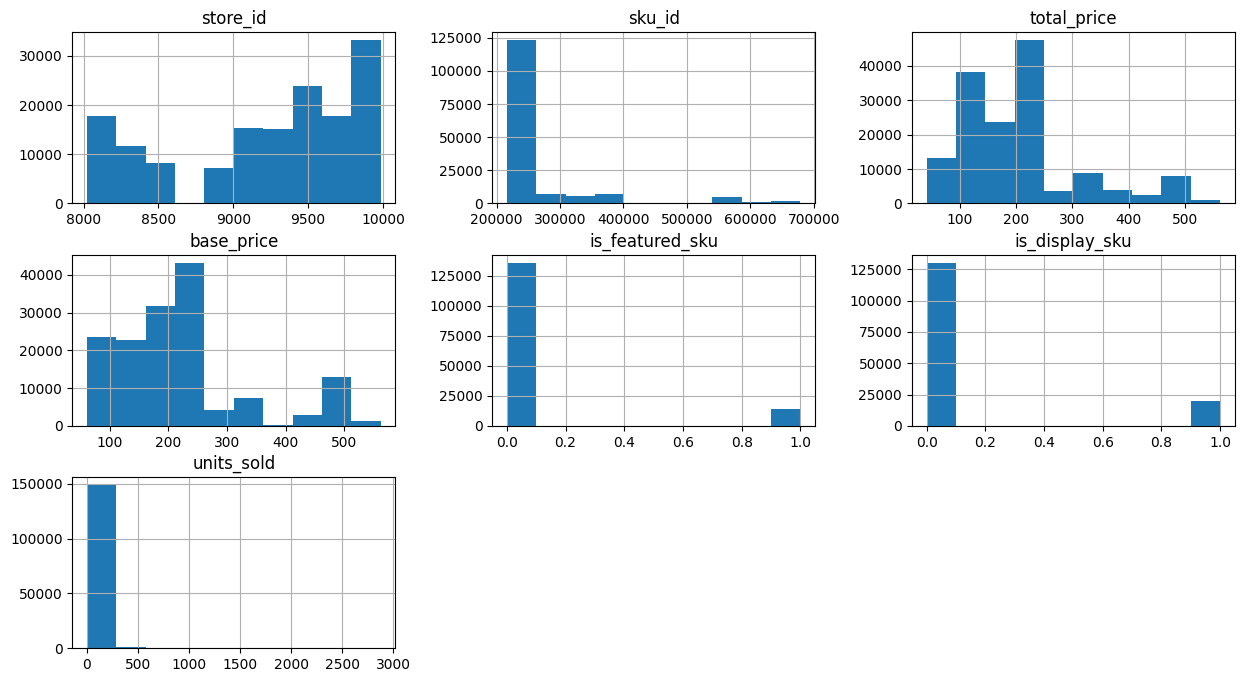

In [3]:
demand_forecasting_data_eda = demand_forecasting_data.drop(columns=['record_ID'])
demand_forecasting_data_eda.hist(figsize=(15, 8))
plt.show()

From the EDA it is possible to understand the distributions and the nature of our variables of our dataset. Through the plots, we can see how it is necessary to work on store_is, sku_id and units_sold. These variables will be pre processed in the next cells.



## Preprocessing

In [4]:
# removing the outliers
demand_forecasting_data = demand_forecasting_data[demand_forecasting_data.units_sold < demand_forecasting_data.units_sold.quantile(0.99)]

# 1 hot encoding for the variable store_id
demand_forecasting_data = demand_forecasting_data.join(pd.get_dummies(demand_forecasting_data.store_id, prefix = 'store'))
demand_forecasting_data = demand_forecasting_data.drop(['store_id'], axis = 1)

# 1 hot encoding for the variable sku_id
demand_forecasting_data = demand_forecasting_data.join(pd.get_dummies(demand_forecasting_data.sku_id, prefix = 'item'))
demand_forecasting_data = demand_forecasting_data.drop(['sku_id'], axis = 1)

# drop the column week and record_ID
demand_forecasting_data = demand_forecasting_data.drop(['week'], axis =1)
demand_forecasting_data = demand_forecasting_data.drop(['record_ID'], axis =1)

demand_forecasting_data

,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_8023,store_8058,store_8063,store_8091,store_8094,...,item_320485,item_327492,item_378934,item_398721,item_545621,item_546789,item_547934,item_600934,item_673209,item_679023
0,99.0375,111.8625,0,0,20,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,99.0375,99.0375,0,0,28,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,133.9500,133.9500,0,0,19,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,133.9500,133.9500,0,0,44,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,141.0750,141.0750,0,0,52,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,235.8375,235.8375,0,0,38,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150146,235.8375,235.8375,0,0,30,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150147,357.6750,483.7875,1,1,31,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150148,141.7875,191.6625,0,1,12,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


The top 1% of the highest units_sold values in the dataset are removed to eliminate extreme outliers. By filtering out unusually high sales, the data becomes cleaner and more suitable for building accurate demand forecasting models.

The 1 hot enconding, is the technique that has been used to manage the variables stored_id and sku_id. This feature processing improved sensibly the performances of the model. It works well in this case because, as long as the Random Forest is based on thresholds, avoids it to create meaningless thresholds related to the ids of the stores, which do not contain information per se, and allows the model to learn specific patterns related to the specific store.

## Models

In [5]:
X, Y = demand_forecasting_data.drop(['units_sold'], axis =1), demand_forecasting_data['units_sold']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

### 1. Random Forest baseline model

In [6]:
model_random_forest_without_hp_t = RandomForestRegressor(n_jobs = -1)
model_random_forest_without_hp_t.fit(X_train, Y_train)

# results

# print the R^2 score for the baseline model
model_random_forest_without_hp_t_R_2_score = model_random_forest_without_hp_t.score(X_test, Y_test)
print("R^2 score for the test set:", model_random_forest_without_hp_t_R_2_score)

# print the root mean squared error (MSE) for the baseline model
Y_pred_model_random_forest_without_hp_t = model_random_forest_without_hp_t.predict(X_test)
root_MSE_model_random_forest_without_hp_t = root_mean_squared_error(Y_pred_model_random_forest_without_hp_t, Y_test)
print("Root MSE for the Random Forest baseline model:", root_MSE_model_random_forest_without_hp_t)

# print the mean absolute error (MAE) for the baseline model
MAE_model_random_forest_without_hp_t = mean_absolute_error(Y_test, Y_pred_model_random_forest_without_hp_t)
print("MAE for the Random Forest baseline model:", MAE_model_random_forest_without_hp_t)

R^2 score for the test set: 0.7809676004550742
Root MSE for the Random Forest baseline model: 19.97757556001309
MAE for the Random Forest baseline model: 12.634930984355309


In [7]:
train_model_random_forest_without_hp_t_R_2_score = model_random_forest_without_hp_t.score(X_train, Y_train)
test_model_random_forest_without_hp_t_R_2_score = model_random_forest_without_hp_t_R_2_score

print("R^2 score for the training set:", train_model_random_forest_without_hp_t_R_2_score)
print("R^2 score for the test set:", test_model_random_forest_without_hp_t_R_2_score)

R^2 score for the training set: 0.9198591497779278
R^2 score for the test set: 0.7809676004550742


### 2. Random Forest with hyperparameter tuning

In [8]:
# parameters setting
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4]
}

model_random_forest_with_hp_t = RandomForestRegressor(n_jobs = -1)
grid_search_random_forest_with_hp_t = GridSearchCV(model_random_forest_with_hp_t, param_grid, verbose = 2, cv = 3)
grid_search_random_forest_with_hp_t.fit(X_train, Y_train)

# results

# print the best estimator combination
best_model_random_forest_with_hp_t = grid_search_random_forest_with_hp_t.best_estimator_
print("The best model is:", best_model_random_forest_with_hp_t)

# print the best parameters combination
best_parameters_random_forest_with_hp_t = grid_search_random_forest_with_hp_t.best_params_
print("The best parameters combination is:", best_parameters_random_forest_with_hp_t)

# print the R^2 score for the best estimator model
best_model_random_forest_with_hp_t_R_2_score = best_model_random_forest_with_hp_t.score(X_test, Y_test)
print("The R^2 score for the best model is:", best_model_random_forest_with_hp_t_R_2_score)

# print the root mean squared error (MSE) for the best estimator model
Y_pred_model_random_forest_with_hp_t = best_model_random_forest_with_hp_t.predict(X_test)
root_MSE_best_model_random_forest_with_hp_t = root_mean_squared_error(Y_pred_model_random_forest_with_hp_t, Y_test)
print("The root MSE for the best model is:", root_MSE_best_model_random_forest_with_hp_t)

# print the mean absolute error (MAE) for the best estimator model
MAE_best_model_random_forest_with_hp_t = mean_absolute_error(Y_test, Y_pred_model_random_forest_with_hp_t)
print("The MAE for the best model is:", MAE_best_model_random_forest_with_hp_t)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   5.5s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   5.6s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   4.7s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  22.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  21.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  21.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  44.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  46.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  42.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time= 1.0min
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time= 1.1min
[CV] END max_depth=10, min_samples_split=2, n_es

In [9]:
# best parameters
best_max_depth = 20
best_min_samples_split = 4


estimators_range = [50, 100, 150, 200, 250, 300]
train_mse = []
test_mse = []
train_mae = []
test_mae = []

for n_estimators in estimators_range:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=best_max_depth,
        min_samples_split=best_min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, Y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse.append(root_mean_squared_error(Y_train, y_train_pred))
    test_mse.append(root_mean_squared_error(Y_test, y_test_pred))
    train_mae.append(mean_absolute_error(Y_train, y_train_pred))
    test_mae.append(mean_absolute_error(Y_test, y_test_pred))

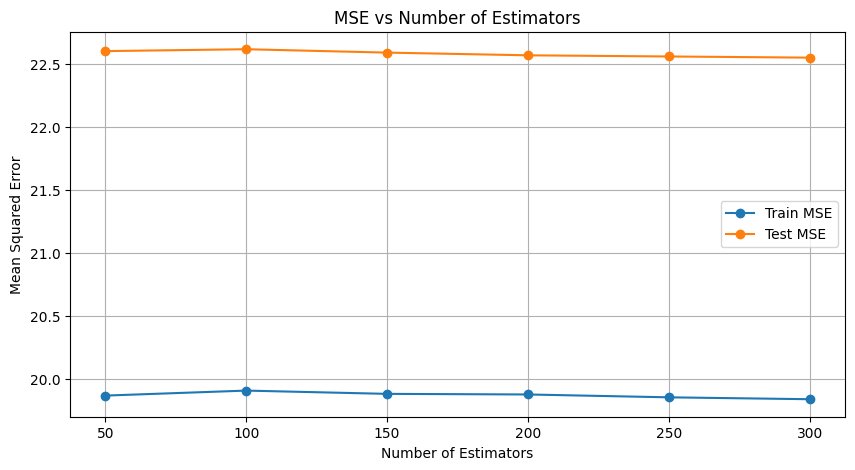

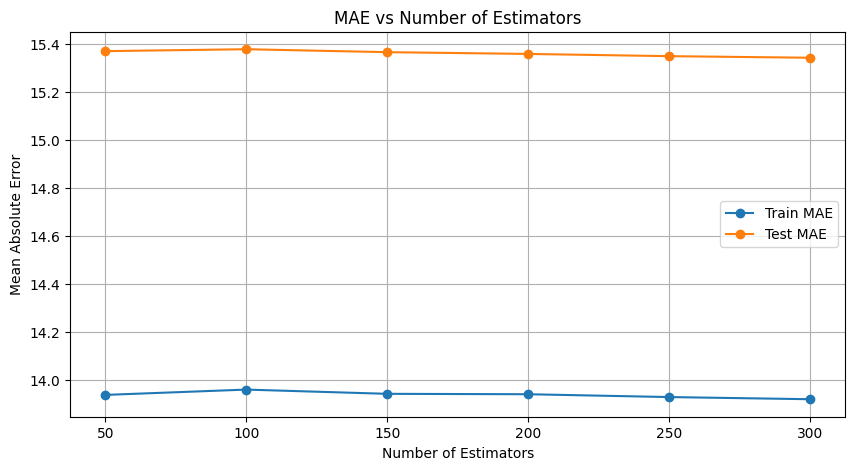

In [10]:
# Plot MSE
plt.figure(figsize=(10, 5))
plt.plot(estimators_range, train_mse, marker='o', label='Train MSE')
plt.plot(estimators_range, test_mse, marker='o', label='Test MSE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(estimators_range, train_mae, marker='o', label='Train MAE')
plt.plot(estimators_range, test_mae, marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
train_best_model_random_forest_with_hp_t_R_2_score = best_model_random_forest_with_hp_t.score(X_train, Y_train)
test_best_model_random_forest_with_hp_t_R_2_score = best_model_random_forest_with_hp_t_R_2_score

print("R^2 score for the training set of the best model:", train_best_model_random_forest_with_hp_t_R_2_score)
print("R^2 score for the test set of the best model:", test_best_model_random_forest_with_hp_t_R_2_score)

R^2 score for the training set of the best model: 0.786208638548165
R^2 score for the test set of the best model: 0.7208075087045037


The output of the graph and the relationship between the train R² and the test R², doesn't seem to lead to overfitting.

### 3. XGBoost

In [12]:
model_xgboost = xgb.XGBRegressor(n_estimators = 200, max_depth = 10)
model_xgboost.fit(X_train, Y_train)

# results

# print the R^2 score for the model xgboost
model_xgboost_R_2_score = model_xgboost.score(X_test, Y_test)
print("The R^2 score for the test set:", model_xgboost_R_2_score)

# print the root mean squared error (MSE) for the model xgboost
Y_pred_model_xgboost = model_xgboost.predict(X_test)
root_MSE_model_xgboost = root_mean_squared_error(Y_pred_model_xgboost, Y_test)
print("The root MSE for the XGBoost model:", root_MSE_model_xgboost)

# print the mean absolute error (MAE) for the model xgboost
MAE_model_xgboost = mean_absolute_error(Y_test, Y_pred_model_xgboost)
print("The MAE for the XGBoost model:", MAE_model_xgboost)

The R^2 score for the test set: 0.8069685101509094
The root MSE for the XGBoost model: 18.754379272460938
The MAE for the XGBoost model: 12.01547908782959


In [13]:
train_model_xgboost_R_2_score = model_xgboost.score(X_train, Y_train)
test_model_xgbosst_R_2_score = model_xgboost_R_2_score

print("R^2 score for the training set of the XGBoost model:", train_best_model_random_forest_with_hp_t_R_2_score)
print("R^2 score for the test set of the XGBoost model:", test_best_model_random_forest_with_hp_t_R_2_score)

R^2 score for the training set of the XGBoost model: 0.786208638548165
R^2 score for the test set of the XGBoost model: 0.7208075087045037


## Comparison between models' performances

In [14]:
results_comparison_dataset = pd.DataFrame({
    'Model': ['Random Forest (base)', 'Random Forest (optimized)', 'XGBoost'],
    'R2 Score': [
        model_random_forest_without_hp_t_R_2_score,
        best_model_random_forest_with_hp_t_R_2_score,
        model_xgboost_R_2_score
    ],
    'RMSE': [
        root_MSE_model_random_forest_without_hp_t,
        root_MSE_best_model_random_forest_with_hp_t,
        root_MSE_model_xgboost
    ],
    'MAE': [
        MAE_model_random_forest_without_hp_t,
        MAE_best_model_random_forest_with_hp_t,
        MAE_model_xgboost]
})

results_comparison_dataset

,Model,R2 Score,RMSE,MAE
0,Random Forest (base),0.780968,19.977576,12.634931
1,Random Forest (optimized),0.720808,22.554877,15.349165
2,XGBoost,0.806969,18.754379,12.015479


From the table, we can see the performance comparison of three regression models using three evaluation metrics: R² Score, Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

The XGBoost model outperforms both Random Forest variants, achieving the highest R² score (0.807), the lowest RMSE (18.75), and the lowest MAE (12.02). This indicates that it captures the variance in the data more effectively and produces more accurate predictions overall.

Then, XGBoost shows the best generalization performance, while the tuning process for Random Forest should be revisited, possibly with a wider parameter grid or more robust validation techniques.

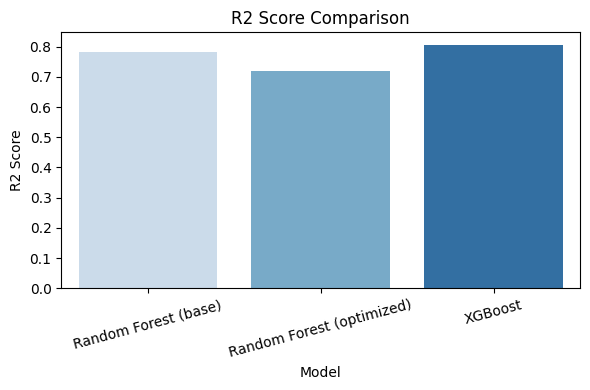

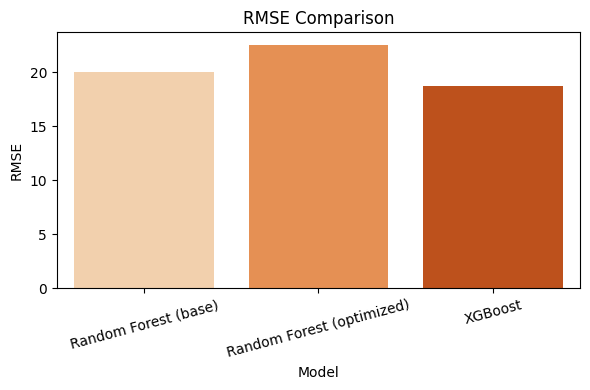

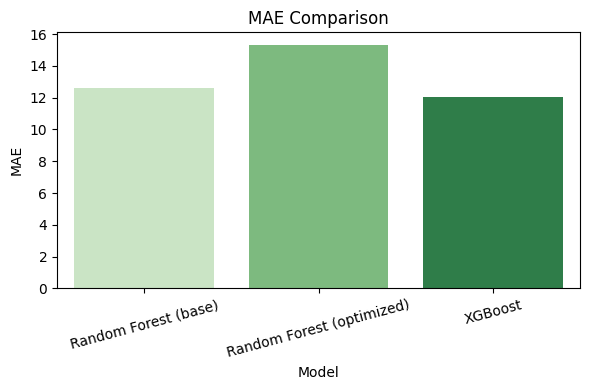

In [15]:
palette_dict = {
    'R2 Score': 'Blues',
    'RMSE': 'Oranges',
    'MAE': 'Greens'
}

metrics = ['R2 Score', 'RMSE', 'MAE']

for metric in metrics:
    plt.figure(figsize=(6, 4))

    sns.barplot(
        data = results_comparison_dataset,
        x = 'Model',
        y = metric,
        hue = 'Model',
        palette = sns.color_palette(palette_dict[metric], n_colors=len(results_comparison_dataset)),
        legend = False
    )

    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

The three bar plots visually compare the performance of the models across key metrics:

- The first plot (in blue) shows the R² scores, highlighting XGBoost’s superior ability to explain variance

- The second plot (in red) displays the RMSE values, where lower bars indicate better accuracy, XGBoost leads with the lowest error

- The third plot (in green) compares MAE, confirming consistent performance trends with XGBoost outperforming both Random Forest models

These color-coded visualizations make it easy to see the strengths and weaknesses of each model at a glance.